В этом ноутбуке мы моделируем убытки по трем кредитам с помощью:
- Логнормального распределения для PD
- Beta-PERT распределения для LGD
- Сравниваем распределения между собой, строим boxplot и violin-плот
- Делаем QQ-Plot для суммарного распределения убытков
- Используем Bootstrap для оценки доверительного интервала для среднего убытка

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
from typing import Dict, Any

## Исходный датафрейм

In [1]:
df_MK = pd.DataFrame(
    {
        "EAD": [1000, 2000, 2500],
        "PD-mean": [0.02, 0.01, 0.015],
        "PD-sigma": [0.007, 0.005, 0.01],
        "LGD-min": [0, 0, 0],
        "LGD-mode": [0.2, 0.3, 0.4],
        "LGD-max": [1, 1, 1],
    },
    index=["Loans A", "Loans B", "Loans C"]
)

df_MK

NameError: name 'pd' is not defined

Функции:
- **simulate_pd_log_normal**: генерирует массив вероятностей дефолта (PD) из лог-нормального распределения  
- **simulate_lgd_beta_pert**: генерирует массив значений LGD по Beta-PERT распределению  
- **calculate_losses**: для каждой строки DataFrame (одного кредита) возвращает массив убытков  
- **plot_histogram**: вспомогательная функция для построения гистограмм  
- **summarize_distribution**: выводит mean, median, percentiles, а также вычисляет bootstrap CI 

In [ ]:
def simulate_pd_log_normal(pd_mean: float, pd_sigma: float, n: int) -> np.ndarray:
    """
    Генерирует выборку PD из лог-нормального распределения
    с заданными средним (pd_mean) и стд. отклонением (pd_sigma).
    """
    sigma_ln = np.sqrt(np.log(1 + (pd_sigma / pd_mean) ** 2))
    mu_ln = np.log(pd_mean) - (sigma_ln ** 2) / 2
    return np.random.lognormal(mean=mu_ln, sigma=sigma_ln, size=n)

def simulate_lgd_beta_pert(a: float, m: float, b: float, n: int) -> np.ndarray:
    """
    Генерирует выборку LGD по Beta-PERT распределению с параметрами (a, m, b).
    """
    if b == a:
        # Чтобы избежать деления на ноль, если b == a, все значения == a
        return np.full(n, a)
    
    pert_mean = (a + 4*m + b) / 6
    alpha = 6 * (pert_mean - a) / (b - a)
    beta = 6 * (b - pert_mean) / (b - a)
    
    beta_samples = np.random.beta(alpha, beta, size=n)
    return a + (b - a) * beta_samples

def calculate_losses(row: pd.Series, n: int) -> np.ndarray:
    """
    Вычисляет массив убытков для одного типа кредита (строки DataFrame).
    """
    ead = row["EAD"]
    pd_mean = row["PD-mean"]
    pd_sigma = row["PD-sigma"]
    
    pd_samples = simulate_pd_log_normal(pd_mean, pd_sigma, n)
    lgd_samples = simulate_lgd_beta_pert(row["LGD-min"], row["LGD-mode"], row["LGD-max"], n)
    
    return ead * pd_samples * lgd_samples

def plot_histogram(data: np.ndarray, title: str, color='blue') -> None:
    """
    Строит гистограмму для выборки data, задаёт заголовок и оси.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=50, edgecolor='black', alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel('Убытки')
    plt.ylabel('Частота')
    plt.grid(True, alpha=0.6)
    plt.show()

#--- NEW FEATURES ---#
def summarize_distribution(data: np.ndarray, name: str = "Data", bootstrap_samples: int = 1000) -> Dict[str, Any]:
    """
    Выводит ключевые статистики (mean, median, percentiles) и проводит
    bootstrap для оценки доверительного интервала среднего значения.
    
    :param data: массив значений
    :param name: имя набора данных (для печати)
    :param bootstrap_samples: число бутстрап-подвыборок
    :return: словарь со статистиками
    """
    mean_val = np.mean(data)
    median_val = np.median(data)
    p95 = np.percentile(data, 95)
    
    # Bootstrap для среднего
    # (случайный выбор с возвращением из data)
    means_boot = []
    n = len(data)
    for _ in range(bootstrap_samples):
        sample_idx = np.random.randint(0, n, n)
        sample = data[sample_idx]
        means_boot.append(np.mean(sample))
    means_boot = np.array(means_boot)
    ci_lower = np.percentile(means_boot, 2.5)
    ci_upper = np.percentile(means_boot, 97.5)
    
    print(f"=== {name} ===")
    print(f"Mean: {mean_val:,.2f}")
    print(f"Median: {median_val:,.2f}")
    print(f"95th percentile: {p95:,.2f}")
    print(f"Bootstrap 95% CI for mean: [{ci_lower:,.2f} ... {ci_upper:,.2f}]")
    print("---------------\n")
    
    return {
        "mean": mean_val,
        "median": median_val,
        "p95": p95,
        "ci_bootstrap": (ci_lower, ci_upper)
    }

### Моделирование

1. Проходим по каждой строке (`Loans A`, `Loans B`, `Loans C`), моделируем 50k сэмплов убытков.  
2. Строим отдельные гистограммы.  
3. Сравниваем распределения — рисуем **boxplot** и **violinplot**.  
4. Складываем убытки, чтобы получить суммарное распределение.  
5. Смотрим статистики: mean, median, 95-й перцентиль, а также bootstrap CI.  
6. Строим **QQ-Plot** для суммарных убытков.

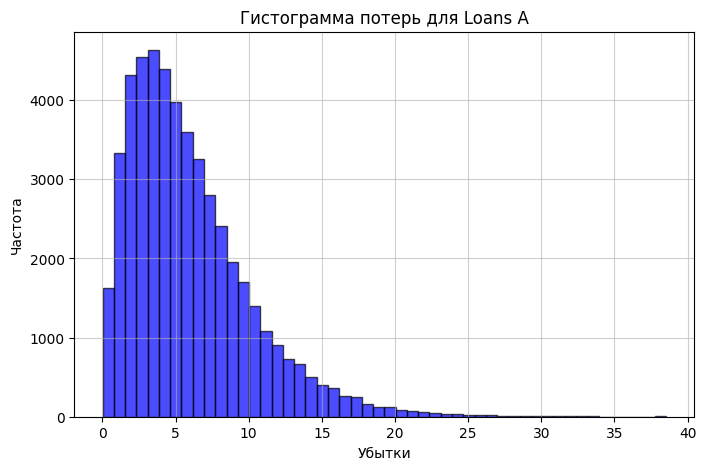

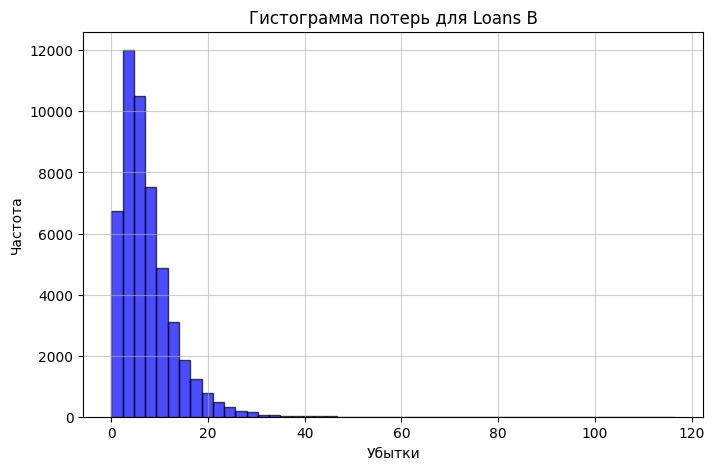

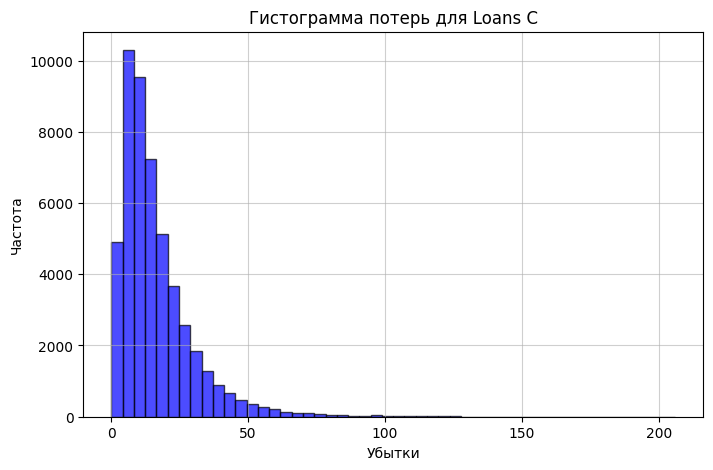

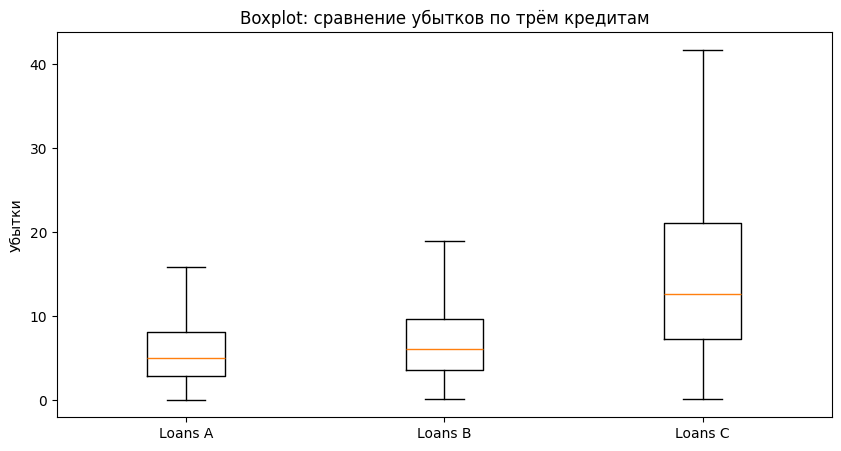

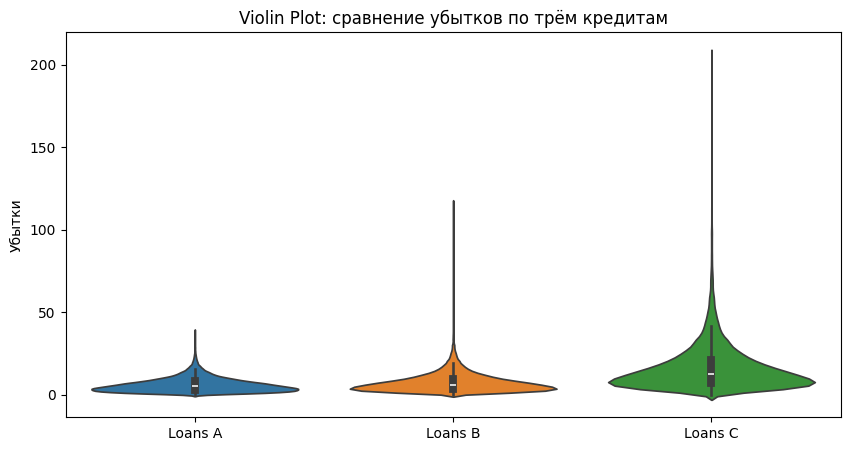

=== Итоговые (Loans A+B+C) ===
Mean: 29.65
Median: 26.46
95th percentile: 57.77
Bootstrap 95% CI for mean: [29.52 ... 29.79]
---------------



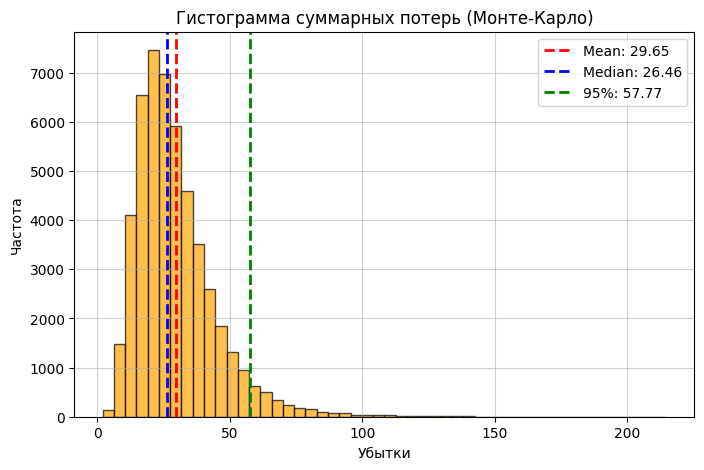

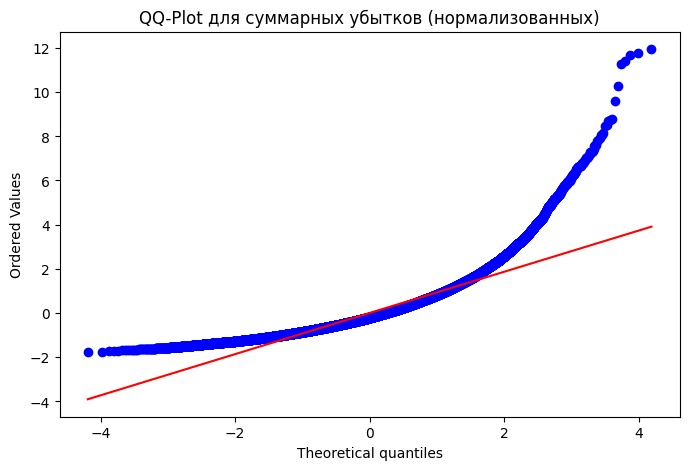

In [ ]:
COUNT = 50_000

# 1. Моделируем убытки по каждому кредиту
losses_by_loan = {}
for loan_name in df_MK.index:
    row = df_MK.loc[loan_name]
    losses = calculate_losses(row, COUNT)
    losses_by_loan[loan_name] = losses
    
    # Гистограмма для каждого
    plot_histogram(losses, f'Гистограмма потерь для {loan_name}')

# 2. Сравнительные графики (Boxplot, Violin)
# --- NEW FEATURES --- 
all_losses_data = []
all_labels = []
for loan_name, arr in losses_by_loan.items():
    all_losses_data.append(arr)
    all_labels.append(loan_name)

plt.figure(figsize=(10,5))
plt.boxplot(all_losses_data, tick_labels=all_labels, showfliers=False)
plt.title('Boxplot: сравнение убытков по трём кредитам')
plt.ylabel('Убытки')
plt.show()

plt.figure(figsize=(10,5))
sns.violinplot(data=all_losses_data)
plt.xticks(ticks=[0,1,2], labels=all_labels)
plt.title('Violin Plot: сравнение убытков по трём кредитам')
plt.ylabel('Убытки')
plt.show()

# 3. Суммарные убытки
losses_total = sum(losses_by_loan.values())

# 4. Статистики + Bootstrap 
summary_total = summarize_distribution(losses_total, name="Итоговые (Loans A+B+C)")

# 5. Гистограмма суммарных убытков
plt.figure(figsize=(8,5))
plt.hist(losses_total, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.axvline(summary_total["mean"], color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {summary_total["mean"]:,.2f}')
plt.axvline(summary_total["median"], color='blue', linestyle='dashed', linewidth=2,
            label=f'Median: {summary_total["median"]:,.2f}')
plt.axvline(summary_total["p95"], color='green', linestyle='dashed', linewidth=2,
            label=f'95%: {summary_total["p95"]:,.2f}')
plt.title('Гистограмма суммарных потерь (Монте-Карло)')
plt.xlabel('Убытки')
plt.ylabel('Частота')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

# 6. QQ-Plot против нормального распределения
# --- NEW FEATURES ---
import scipy.stats as st

mean_ = summary_total["mean"]
std_ = np.std(losses_total)

z = (losses_total - mean_) / std_
# используем st.probplot, чтобы построить QQ-Plot
fig = plt.figure(figsize=(8,5))
res = st.probplot(z, dist="norm", plot=plt)
plt.title("QQ-Plot для суммарных убытков (нормализованных)")
plt.show()

##  Итоги проекта

В этом проекте реализовано моделирование кредитных потерь методом Монте-Карло с учётом:
- логнормального распределения PD
- Beta-PERT распределения LGD
- параметров трёх типов кредитов

Проведён анализ:
- Сгенерированы 50 000 сценариев на каждый кредит
- Построены гистограммы, boxplot и violin-плоты
- Рассчитаны средние потери, медиана и 95-й перцентиль
- Проведён bootstrap-анализ для оценки доверительного интервала среднего значения
- Построен QQ-Plot, показавший отклонение от нормального распределения

Вывод:
- Итоговое распределение потерь асимметрично, с длинным хвостом
- 95% перцентиль может использоваться как Value-at-Risk
- Проект демонстрирует навыки моделирования, визуализации и анализа данных в контексте оценки рисков


In [ ]:
git init

SyntaxError: invalid syntax (2830201818.py, line 1)